# Problem Statement

 build a machine learning-based approach to predict the CTR of an email campaign
 
 ## Step 1: Importing Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Step 2: Data Inspection

In [4]:
# we can comment this cell if working on local machine
# while working on colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks


In [5]:
train = pd.read_csv('train_F3fUq2S.csv')
test = pd.read_csv('test_Bk2wfZ3.csv')

In [6]:
# rows and columns
train.shape, test.shape

((1888, 22), (762, 21))

In [7]:
train.sample(5)

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
1072,1073,3,96,15629,34,2,0,Evening,15,6,...,2,0,4,0,0,0,0,1,12,0.007820
181,182,3,102,12658,29,0,0,Evening,6,26,...,1,0,1,0,0,0,0,0,5,0.004500
567,568,3,97,19142,25,2,0,Evening,15,6,...,0,0,0,0,0,0,0,1,12,0.002979
1771,1772,15,90,39774,14,3,0,Morning,15,24,...,2,0,2,0,0,0,0,0,12,0.030181
1489,1490,10,51,9250,46,2,0,Evening,15,13,...,1,1,3,0,0,0,0,0,12,0.000000


* __We have 22 columns including target feature.__
* __Mostly We have Numerical data, except 1 column__

In [8]:
# checking null rows in %
train.isnull().sum()//train.shape[0]*100

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

In [9]:
test.isnull().sum()//train.shape[0]*100

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
dtype: int64

* __Looks like we don't have any Empty rows in dataset__

In [10]:
#Categorical data
categorical_train = train.select_dtypes(include=np.object)
print(f'We have {categorical_train.shape[1]} Categorical features in Train.')

categorical_test = test.select_dtypes(include=np.object)
print(f'We have {categorical_test.shape[1]} Categorical features in Test.')

We have 1 Categorical features in Train.
We have 1 Categorical features in Test.


In [11]:
# list of numerical features
numerical_train = train.select_dtypes(include=[np.int64, np.float64])
print(f'We have {numerical_train.shape[1]} Numerical features in Train.')

numerical_test = test.select_dtypes(include=[np.int64, np.float64])
print(f'We have {numerical_test.shape[1]} Numerical features in Test.')

We have 21 Numerical features in Train.
We have 20 Numerical features in Test.


In [12]:
# train_nuni = (train.count() - train.nunique())/train.count()*100
# test_nuni = (train.count() - train.nunique())/train.count()*100
# categorical_train = train_nuni[train_nuni>=90]
# categorical_test = test_nuni[test_nuni>=90]

# numerical_train = train_nuni[train_nuni<90]
# numerical_test = test_nuni[test_nuni<90]
# #print(categorical)
# print(f"\nWe have total {categorical_train.shape[0]} Categorical features and {numerical_train.shape[0]} Quantitative data for Training dataset")
# print(f"\nWe have total {categorical_test.shape[0]} Categorical features and {numerical_test.shape[0]} Quantitative data for testing dataset")

In [13]:
train.nunique()

campaign_id           1888
sender                  12
subject_len            170
body_len              1568
mean_paragraph_len     121
day_of_week              7
is_weekend               2
times_of_day             3
category                16
product                 43
no_of_CTA               40
mean_CTA_len            79
is_image                 6
is_personalised          2
is_quote                 7
is_timer                 1
is_emoticons             6
is_discount              2
is_price                 8
is_urgency               2
target_audience         17
click_rate            1810
dtype: int64

In [14]:
# we observe is_timer feature contain only single unique value
# lets check

train['is_timer'].value_counts()

0    1888
Name: is_timer, dtype: int64

* __'is_timer' contains same data, which will not help us predicting target__

In [15]:
encoder = LabelEncoder()
encoder.fit(train['times_of_day'])

train['time_of_day_enc'] = encoder.transform(train['times_of_day'])
test['time_of_day_enc'] = encoder.transform(test['times_of_day'])

In [16]:
# we will drop time_of_day text field as we have created new
new_train = train.drop(columns=['times_of_day','is_timer'])
new_test = test.drop(columns=['times_of_day','is_timer'])

## Step 3: Exploratory Data Analysis

In [17]:
new_train.columns

Index(['campaign_id', 'sender', 'subject_len', 'body_len',
       'mean_paragraph_len', 'day_of_week', 'is_weekend', 'category',
       'product', 'no_of_CTA', 'mean_CTA_len', 'is_image', 'is_personalised',
       'is_quote', 'is_emoticons', 'is_discount', 'is_price', 'is_urgency',
       'target_audience', 'click_rate', 'time_of_day_enc'],
      dtype='object')

In [18]:
print(new_train['time_of_day_enc'].value_counts())
print('*'*20)
print(new_test['time_of_day_enc'].value_counts())

0    1317
2     447
1     124
Name: time_of_day_enc, dtype: int64
********************
0    532
2    175
1     55
Name: time_of_day_enc, dtype: int64


__Finding Correlation__

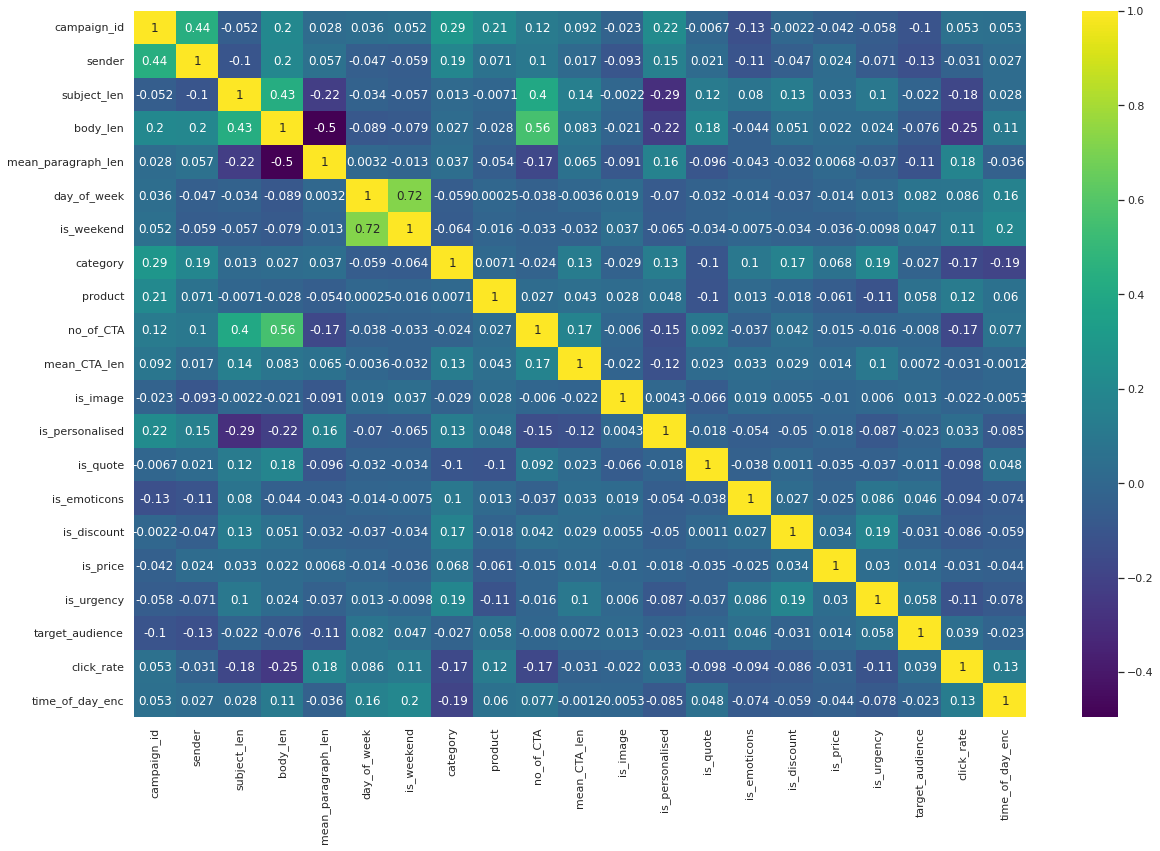

In [19]:
corr_train = new_train.corr()

plt.figure(figsize=[20,13])
sns.heatmap(corr_train, annot=True, cmap='viridis')

__Correlation is high,__ 
* between no_of_CTA, body_len
* between is_weekned, day_of_week

__We will drop one of this columns, here body_len and day_of_week will drop__

In [20]:
# FINDING CORRELATION wrt tagregt variable
# Thanks to: https://www.kaggle.com/sid321axn/house-price-prediction-gboosting-adaboost-etc

featuress = new_train.drop(columns=['click_rate','body_len','day_of_week']).columns.tolist()
target = new_train['click_rate'].name

In [21]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlations = {}
for f in featuress:
    data_temp = new_train[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

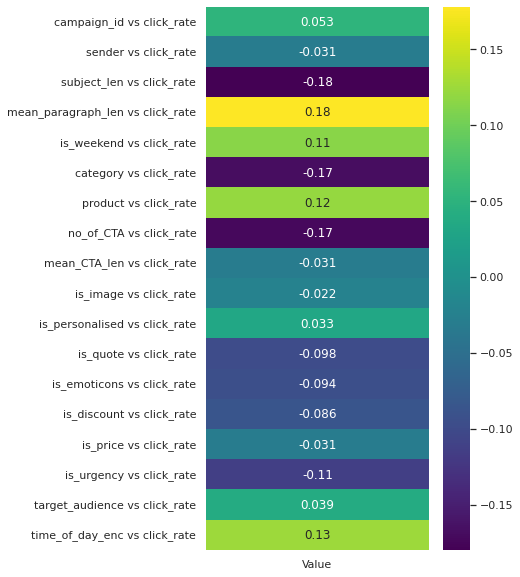

In [22]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

# plot heatmap 
plt.figure(figsize=(5,10))
sns.heatmap(data_correlations, annot=True, cmap='viridis')

In [23]:
# campign_id is just ID col, which is not affect taregt
# we will drop that
# THIS WILL BE FINAL TRAIN AND TEST SETS
# NO CHANGES WILL BE THERE AFTER THIS
new_train = new_train.drop(columns=['campaign_id'])
new_test = new_test.drop(columns=['campaign_id'])

In [24]:
# Separating input and output variables
X= new_train.drop(columns=['click_rate'])
y = new_train['click_rate']

## Step 4: Model Creation
Separating training data into train and validation 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=54)

__Scaling data with standarscaler()__

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_scaled = scaler.transform(new_test)

__Feature Selection__<br>
We will use Lasso Regression for Feature Selection

In [27]:
# feature selection
search = GridSearchCV(Lasso(), {'alpha':[0.01,0.02, 0.024, 0.025, 0.026, 0.03]})
search.fit(X_train_scaled, y_train)
coef = search.best_estimator_.coef_
features = list(np.array(X_train.columns.to_list())[coef==0])
features

['sender',
 'mean_paragraph_len',
 'day_of_week',
 'is_weekend',
 'product',
 'no_of_CTA',
 'mean_CTA_len',
 'is_image',
 'is_personalised',
 'is_quote',
 'is_emoticons',
 'is_discount',
 'is_price',
 'is_urgency',
 'target_audience']

In [28]:
features = ['body_len','day_of_week']
X_train_feat = X_train.drop(columns=features)
X_test_feat = X_test.drop(columns=features)

In [29]:
# Scaling feature selection data 
scaler1 = StandardScaler()
X_train_fs = scaler.fit_transform(X_train_feat)
X_test_fs = scaler.transform(X_test_feat)
test_fs = scaler.transform(new_test.drop(columns=features))

In [76]:
# THANKS TO https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb

def metric_calc(model, xtrain, ytrain, xtest, ytest):
    """
    To plot the metrics and graph of regression
    ==============================================
    inputs:
      model: Model selected
      xtrain: input for train
      ytrain: ground truth for xtrain
      xtest: input for test
      ytest: ground truth for xtest
    outputs:
      PRINT --> Metrics R2_score, MAE, MSE, RMSE for both Train and validation
      RETURN --> Metrics for Validation

    """
    y_pred_train = model.predict(xtrain)
    r2_train = r2_score(ytrain,y_pred_train)
    mae_train = mean_absolute_error(ytrain,y_pred_train)
    mse_train = mean_squared_error(ytrain,y_pred_train)
    rmse_train = np.sqrt(mse_train)    
    
    metrics_train = {}
    metrics_train['R2_Score'] = r2_train
    metrics_train['MAE'] = mae_train
    metrics_train['MSE'] = mse_train
    metrics_train['RMSE'] = rmse_train
    
    y_pred = model.predict(xtest)
    r2 = r2_score(ytest,y_pred)
    mae = mean_absolute_error(ytest,y_pred)
    mse = mean_squared_error(ytest, y_pred)
    rmse = np.sqrt(mse)
    
    metrics = {}
    metrics['R2_Score'] = r2
    metrics['MAE'] = mae
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse

    print("="*20,"Model Metrics - Train","="*20)
    print(pd.DataFrame([metrics_train]))    
    print("\n")
    print("="*20,"Model Metrics - Test","="*20)
    print(pd.DataFrame([metrics]))
    
    return metrics

#### 4.1 Linear Regression

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_reg_metrics = metric_calc(linear_model,X_train_scaled,y_train, X_test_scaled, y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.143222  0.045893  0.005924  0.076965


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0   0.15065  0.043637  0.006605  0.081272


__with feature selection__

In [32]:
linear_model1 = LinearRegression()
linear_model1.fit(X_train_fs, y_train)
linear_reg_fs_metrics = metric_calc(linear_model1,X_train_fs,y_train, X_test_fs, y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.131184  0.045891  0.006007  0.077504


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0   0.16636  0.042069  0.006483  0.080517


#### 4.2 Lasso Regression

In [33]:
search = GridSearchCV(Lasso(),param_grid={'alpha':np.arange(0.001,1,0.02)})
search.fit(X_train_scaled,y_train)
search.best_params_

{'alpha': 0.001}

In [34]:
lasso_model = Lasso(**search.best_params_)
lasso_model.fit(X_train_scaled,y_train)
lasso_metrics = metric_calc(lasso_model,X_train_scaled,y_train, X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score      MAE       MSE      RMSE
0  0.141132  0.04537  0.005938  0.077059


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.146005  0.042938  0.006641  0.081494


__With selected features__

In [35]:
search = GridSearchCV(Lasso(),param_grid={'alpha':np.arange(0.001,1,0.02)})
search.fit(X_train_fs,y_train)
search.best_params_

{'alpha': 0.001}

In [36]:
lasso_model1 = Lasso(**search.best_params_)
lasso_model1.fit(X_train_fs,y_train)
lasso_fs_metrics = metric_calc(lasso_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE      MSE      RMSE
0   0.12921  0.045291  0.00602  0.077592


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.162309  0.041437  0.006515  0.080713


#### 4.3 Ridge Regression

In [37]:
search = GridSearchCV(Ridge(),param_grid={'alpha':np.arange(0.001,1,0.02)})
search.fit(X_train_scaled,y_train)
search.best_params_

{'alpha': 0.981}

In [38]:
ridge_model = Ridge(**search.best_params_)
ridge_model.fit(X_train_scaled, y_train)
ridge_metrics = metric_calc(ridge_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score      MAE       MSE      RMSE
0  0.143222  0.04589  0.005924  0.076965


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.150664  0.043632  0.006605  0.081272


__With Selected Features__

In [39]:
search = GridSearchCV(Ridge(),param_grid={'alpha':np.arange(0.001,1,0.02)})
search.fit(X_train_fs,y_train)
search.best_params_

{'alpha': 0.981}

In [40]:
ridge_model1 = Ridge(**search.best_params_)
ridge_model1.fit(X_train_fs, y_train)
ridge_fs_metrics = metric_calc(ridge_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.131184  0.045888  0.006007  0.077504


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0   0.16634  0.042066  0.006483  0.080518


#### 4.4 SVR

In [41]:
# From here most of the Gridsearchcv code is commented
#as it takes long time to run

# search = GridSearchCV(SVR(),param_grid={'kernel':['rbf','poly'],'degree':np.arange(1,5,1)
#                                         ,'epsilon':np.arange(0.01,1,0.02),'C':np.arange(0.1,3,0.5)})
# search.fit(X_train_scaled,y_train)
# search.best_params_

In [42]:
svr_model = SVR(C=1.1,epsilon=0.01, kernel='rbf')
svr_model.fit(X_train_scaled,y_train)
svr_metrics = metric_calc(svr_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.598878  0.021135  0.002773  0.052662


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.449958  0.034678  0.004278  0.065403


__With Feature selection__

In [43]:
# search = GridSearchCV(SVR(),param_grid={'kernel':['rbf','poly'],'degree':np.arange(1,5,1)
#                                         ,'epsilon':np.arange(0.01,1,0.02),'C':np.arange(0.1,3,0.5)})
# search.fit(X_train_fs,y_train)
# search.best_params_

In [44]:
svr_model1 = SVR(C=1.1,epsilon=0.01, kernel='rbf')
svr_model1.fit(X_train_fs,y_train)
svr_fs_metrics = metric_calc(svr_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.530036  0.023329  0.003249  0.057002


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.382114  0.035214  0.004805  0.069319


#### 4.5 DecisionTree Regressor

In [45]:
# search = GridSearchCV(DecisionTreeRegressor(),param_grid={'splitter':["best","random"],'max_depth':np.arange(1,32,1)
#                                         ,'min_samples_leaf':np.arange(1,10,1),'max_features':["auto","log2","sqrt",None],
#                                             'random_state':[100]}, cv=5)
# search.fit(X_train_scaled,y_train)
# search.best_params_

In [46]:
dtr_model = DecisionTreeRegressor(criterion='absolute_error',max_depth=14,max_features='log2',min_samples_leaf=9,random_state=100, splitter='best')
dtr_model.fit(X_train_scaled,y_train)
dtr_metrics = metric_calc(dtr_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0    0.4686  0.026133  0.003674  0.060614


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.207457  0.032961  0.006163  0.078507


__With Feature Selection__

In [47]:
# search = GridSearchCV(DecisionTreeRegressor(),param_grid={'splitter':["best","random"],'max_depth':np.arange(1,32,1)
#                                                 ,'criterion':['squared_error', 'absolute_error'],
#                                         'min_samples_leaf':np.arange(1,10,1),'max_features':["auto","log2","sqrt",None],
#                                             'random_state':[100]}, cv=5)
# search.fit(X_train_fs,y_train)
# search.best_params_

In [48]:
dtr_model1 = DecisionTreeRegressor(criterion='absolute_error',max_depth=9,max_features='auto',min_samples_leaf=2,random_state=100, splitter='best')
dtr_model1.fit(X_train_fs,y_train)
dtr_fs_metrics = metric_calc(dtr_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.534579  0.021601  0.003218  0.056726


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.223228  0.027973  0.006041  0.077722


#### 4.6 RandomForest Regressor

In [49]:
# search = GridSearchCV(RandomForestRegressor(),param_grid={'n_estimators':[100,500,1000],'max_depth':np.arange(8,32,1),
#                                             'min_samples_leaf':np.arange(0.01,1.0,0.05),
#                                             'random_state':[100]}, cv=5)
# search.fit(X_train_fs,y_train)
# search.best_params_

In [50]:
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.001,max_depth=32,random_state=100)
rf_model.fit(X_train_scaled,y_train)
rf_model = metric_calc(rf_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE     RMSE
0  0.869303  0.015114  0.000904  0.03006


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.507766  0.030231  0.003828  0.061871


__with feature selection__

In [51]:
# search = GridSearchCV(RandomForestRegressor(),param_grid={'n_estimators':[50,100,150,200,500,1000],'max_depth':np.arange(8,32,1),
#                                             'min_samples_leaf':np.arange(1,10,1),'max_features':["auto","log2","sqrt",None],
#                                             'random_state':[100]}, cv=5)
# search.fit(X_train_fs,y_train)
# search.best_params_

In [52]:
rf_model1 = RandomForestRegressor(n_estimators=1000, min_samples_leaf=0.001,max_depth=32,random_state=100)
rf_model1.fit(X_train_fs,y_train)
rf_fs_model = metric_calc(rf_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0   0.83298  0.016744  0.001155  0.033982


==================== Model Metrics - Test ====================
   R2_Score      MAE       MSE      RMSE
0  0.486034  0.03103  0.003997  0.063222


#### 4.7 AdaBoosting Regressor

In [51]:
# search = GridSearchCV(AdaBoostRegressor(),param_grid={#'n_estimators':[50,100,150,200,500,1000],
#                                             'learning_rate':np.arange(0.001,1,0.3),
#                                             'random_state':[100]}, cv=5)
# search.fit(X_train_scaled,y_train)
# search.best_params_

In [58]:
adboost_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(),  n_estimators=500, learning_rate=0.001, random_state=100)
adboost_model.fit(X_train_scaled,y_train)
adboost_metrics = metric_calc(adboost_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.938841  0.011471  0.000423  0.020563


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.552317  0.030299  0.003482  0.059004


__with feature selection__

In [59]:
adboost_model1 = AdaBoostRegressor(base_estimator=RandomForestRegressor(),  n_estimators=500, learning_rate=0.001, random_state=100)
adboost_model1.fit(X_train_fs,y_train)
adboost_fs_metrics = metric_calc(adboost_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.927059  0.012478  0.000504  0.022457


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE      RMSE
0  0.550983  0.030853  0.003492  0.059092


#### 4.8 Gradient Boosting Regressor

In [53]:
# search = GridSearchCV(GradientBoostingRegressor(),param_grid={#'n_estimators':[500],
#                                             'learning_rate':np.arange(0.001,1,0.3),
#                                             'random_state':[100],'criterion':['friedman_mse','squared_error'],
#                                             'min_samples_split':np.arange(0.01,1,0.005)},
#                                           cv=5)
# search.fit(X_train_scaled,y_train)
# search.best_params_

In [54]:
gbdt_model = GradientBoostingRegressor(n_estimators=160,learning_rate=0.301,min_samples_split=0.209996,criterion='friedman_mse',random_state=100)
gbdt_model.fit(X_train_scaled,y_train)
gbdt_metrics = metric_calc(gbdt_model,X_train_scaled,y_train,X_test_scaled,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.785658  0.024211  0.001482  0.038496


==================== Model Metrics - Test ====================
   R2_Score       MAE      MSE      RMSE
0  0.501084  0.035593  0.00388  0.062289


__with feature selection__

In [55]:
gbdt_model1 = GradientBoostingRegressor(n_estimators=160,learning_rate=0.311,min_samples_split=0.209996,criterion='friedman_mse',random_state=100)
gbdt_model1.fit(X_train_fs,y_train)
gbdt_fs_metrics = metric_calc(gbdt_model1,X_train_fs,y_train,X_test_fs,y_test)

==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0    0.6706  0.029279  0.002277  0.047722


==================== Model Metrics - Test ====================
   R2_Score       MAE       MSE    RMSE
0  0.558436  0.036203  0.003434  0.0586


#### 4.9 Xgboost Regressor

In [77]:
# search = GridSearchCV(XGBRegressor(),param_grid={#'n_estimators':[50,100,150,200,500,1000],
#                                             'learning_rate':np.arange(0.001,1,0.3),
#                                             'random_state':[100],'criterion':['friedman_mse','squared_error'],
#                                             'min_samples_split':np.arange(0.01,1,0.005),'max_depth':np.arange(8,32,1)},
#                                           cv=5)
# search.fit(X_train_scaled,y_train)
# search.best_params_

In [56]:
xgb_model = XGBRegressor(n_estimators=1000, max_depth=8, eta=0.315,subsample=0.7,colsample_bytree=0.8)
xgb_model.fit(X_train_scaled,y_train)
xgb_metrics = metric_calc(xgb_model,X_train_scaled,y_train,X_test_scaled,y_test)

[12:56:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Model Metrics - Train ====================
   R2_Score       MAE           MSE      RMSE
0   0.99994  0.000443  4.130856e-07  0.000643


==================== Model Metrics - Test ====================
   R2_Score      MAE       MSE      RMSE
0  0.617749  0.02921  0.002973  0.054522


In [57]:
xgb_model1 = XGBRegressor(n_estimators=1000, max_depth=8, eta=0.3, subsample=0.7, colsample_bytree=0.8)
xgb_model1.fit(X_train_fs,y_train)
xgb_fs_metrics = metric_calc(xgb_model1,X_train_fs,y_train,X_test_fs,y_test)

[12:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
==================== Model Metrics - Train ====================
   R2_Score       MAE       MSE      RMSE
0  0.995852  0.001262  0.000029  0.005355


==================== Model Metrics - Test ====================
   R2_Score       MAE      MSE      RMSE
0  0.555144  0.031098  0.00346  0.058818


### Model Analysis
As we have tried to fit our dataset with various models, its time to take look on metrics for selecting best among them. <br>
We will be focusing more on __RMSE__, if RMSE is low, better the model. 

In [60]:
models_indx = ['Linear Regression','Lasso Regression','Ridge Regression','SVR','DecisionTree Regressor',
               'RandomForest Regressor','AdaBoost Regressor','GBDT Regressor','XGBoost Regressor']

ML_Comparison = pd.DataFrame([linear_reg_metrics,lasso_metrics,ridge_metrics,svr_metrics,dtr_metrics,
                             rf_model,adboost_metrics,gbdt_metrics,xgb_metrics], 
                             index=models_indx)

In [61]:
models_indx = ['Linear Regression(FS)','Lasso Regression(FS)','Ridge Regression(FS)','SVR(FS)','DecisionTree Regressor(FS)',
               'RandomForest Regressor(FS)','AdaBoost Regressor(FS)','GBDT Regressor(FS)','XGBoost Regressor(FS)']

ML_Comparison1 = pd.DataFrame([linear_reg_fs_metrics,lasso_fs_metrics,ridge_fs_metrics,svr_fs_metrics,dtr_fs_metrics,
                             rf_fs_model,adboost_fs_metrics,gbdt_fs_metrics,xgb_fs_metrics], 
                             index=models_indx)

In [67]:
FINAL_COMPARISON = pd.concat([ML_Comparison,ML_Comparison1])
FINAL_COMPARISON.sort_values(by='RMSE',ascending=True,inplace=True)
FINAL_COMPARISON

,R2_Score,MAE,MSE,RMSE
XGBoost Regressor,0.617749,0.029210,0.002973,0.054522
GBDT Regressor(FS),0.558436,0.036203,0.003434,0.058600
XGBoost Regressor(FS),0.555144,0.031098,0.003460,0.058818
AdaBoost Regressor,0.552317,0.030299,0.003482,0.059004
AdaBoost Regressor(FS),0.550983,0.030853,0.003492,0.059092
RandomForest Regressor,0.507766,0.030231,0.003828,0.061871
GBDT Regressor,0.501084,0.035593,0.003880,0.062289
RandomForest Regressor(FS),0.486034,0.031030,0.003997,0.063222
SVR,0.449958,0.034678,0.004278,0.065403
SVR(FS),0.382114,0.035214,0.004805,0.069319


As per above results, we can see __RMSE__ is minimum for __XGBoost__ model without feature selection. We will use that for prediction.

## Submission
We will save predictions into CSV file

In [73]:
submission = pd.DataFrame(columns=['campaign_id','click_rate'])

In [70]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', XGBRegressor(n_estimators=1000, max_depth=8, eta=0.315,subsample=0.7,colsample_bytree=0.8))])
pipe.fit(X,y)

#final_model = XGBRegressor(n_estimators=1000, max_depth=8, eta=0.315,subsample=0.7,colsample_bytree=0.8)
# final_model.fit(X_train_scaled,y_train)

[13:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9999352087562866

In [71]:
prediction = pipe.predict(new_test)

In [74]:
submission['campaign_id'] = test['campaign_id']
submission['click_rate'] = prediction
submission.sample(10)

,campaign_id,click_rate
323,2212,0.006928
527,2416,0.025507
83,1972,0.007317
540,2429,0.046548
96,1985,0.013141
485,2374,0.033881
408,2297,0.016107
738,2627,0.043188
8,1897,0.002698
471,2360,0.009181


In [75]:
# save output as csv
submission.to_csv('xgboost_submission.csv',index=False)

## References
* FINDING CORRELATION code inspired [kaggle-user](https://www.kaggle.com/sid321axn/house-price-prediction-gboosting-adaboost-etc)
* METRIC_CALC function inspired by [github.com/prateeknigam9/Hinglish_Classifier](https://github.com/prateeknigam9/Hinglish_Classifier/blob/main/CaseStudy_Hinglish.ipynb)
* [Feature engineering - towards datascience](https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e)
* [sklearn](https://scikit-learn.org/stable/user_guide.html)
* [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)